<a href="https://colab.research.google.com/github/Airinelizabath/duplicate_question_detection/blob/main/nlpminiproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Duplicate Question Detection**

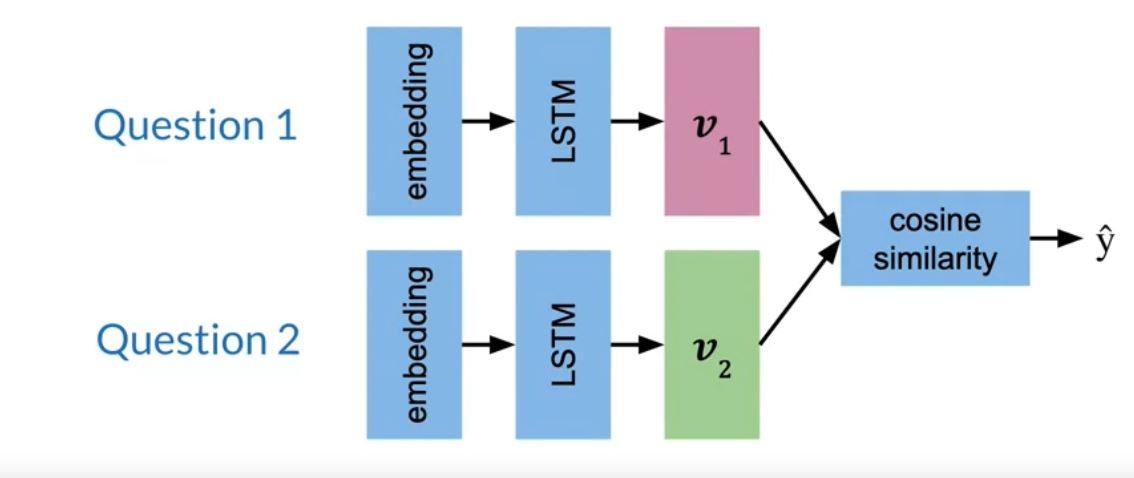

In [ ]:
import python_utils

In [ ]:
!pip install trax==1.3.1

**`Importing the Packages and Data`**

**1. Load the packages**

In [ ]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
trax.supervised.trainer_lib.init_random_number_generators(34)
rnd.seed(34)

**2. Import Quora Dataset wich consists of 404351 records**


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/questions.csv")
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
N_train = 300000
N_test  = 10*1024
data_train = data[:N_train]
data_test  = data[N_train:N_train+N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del(data) # remove to free memory

Train set: 300000 Test set: 10240


In [ ]:
data_test.head()

,id,qid1,qid2,question1,question2,is_duplicate
300000,300000,589215,589216,How do I prepare for interviews for cse?,What is the best way to prepare for cse?,0
300001,300001,589217,589218,What is the best bicycle to buy under 10k?,Which is the best bike in in dia to buy in INR...,1
300002,300002,589219,589220,How do I become Mutual funds distributer for a...,How do I become mutual funds distributor for a...,1
300003,300003,589221,589222,Will this relationship work?,Relationship: Will this relationship work?,0
300004,300004,589223,589224,How does Brexit affect India?,Will the GBP/AUD be affected by Brexit?,0


**4. Assign only question pairs which are duplicates to train data (is_duplicate=1).**

We build two batches as input for the Siamese network and assume that question  𝑞1𝑖  (question  𝑖  in the first batch) is a duplicate of  𝑞2𝑖  (question  𝑖  in the second batch), but all other questions in the second batch are not duplicates of  𝑞1𝑖 .

In [ ]:
td_index = (data_train['is_duplicate'] == 1).to_numpy() #index of question pairs where is_duplicate=1
td_index = [i for i, x in enumerate(td_index) if x]  #count
print('number of duplicate questions: ', len(td_index))  #td_index conrains indexes with duplicate words
print('indexes of first ten duplicate questions:', td_index[:10])

number of duplicate questions:  111486
indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [ ]:
Q1_train_words = np.array(data_train['question1'][td_index]) #for training only duplicate words are used  (triple loss)
Q2_train_words = np.array(data_train['question2'][td_index])
Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

In [ ]:
#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)
Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

**5. Build a vocabulary, vocab**  
This a dictionary of words in the training set where each word in the training set is mapped to a number. All the new words which will come will be mapped to 0 by default.

In [ ]:
# Building the vocabulary with the train set         
from collections import defaultdict
vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1
for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  36342


**6. Converting words to tensor**
  a. Tokenization (train data are already tokenized in the previous step)
  b. Assign numbers from the vocab.

In [ ]:
for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [ ]:
print('Train set has reduced to: ', len(Q1_train), len(Q2_train) ) 
print('Test set length: ', len(Q1_test),len(Q2_test) ) 

Train set has reduced to:  111486 111486
Test set length:  10240 10240


In [ ]:

for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [ ]:
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
[32, 38, 4, 107, 65, 1015, 65, 11522, 21]


**7. Splitting data for training and validation set**

In [ ]:
# Splitting the data
cut_off = int(len(Q1_train)*.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


**8. Data generator**  
1. Questions are inputed as batches.
2. Pad every question by vocab['\<PAD\>'] until you get the length max_len

In [ ]:
# data_generator     #batch training
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)    
    question_indexes = [*range(len_q)]
    
    if shuffle:                           #if shuffle is true
        rnd.shuffle(question_indexes)   
  
    while True:
        if idx >= len_q:                 #if index > len(Q1) set index to 0 ,   Q1 is either a batch of questions in training or testing or can be a question in case of prediction
            idx = 0
            if shuffle:
                rnd.shuffle(question_indexes)
        

        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]
        idx += 1
        input1.append(q1)    #append the questions in Q1 in each iteration until it raches the batch size
        input2.append(q2)

        if len(input1) == batch_size:
            max_len = max(max([len(q) for q in input1]),max([len(q) for q in input2]))
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = []
            b2 = []
            for q1, q2 in zip(input1, input2):
                q1 =q1 + [pad] * (max_len - len(q1))
                q2 = q2 + [pad] * (max_len - len(q2))
                b1.append(q1)
                b2.append(q2)
            yield np.array(b1), np.array(b2)
            input1, input2 = [], []  

In [ ]:
batch_size = 2
res1, res2 = next(data_generator(train_Q1, train_Q2, batch_size))
print("First questions  : ",'\n', res1, '\n')
print("Second questions : ",'\n', res2)
print(len(train_Q1))

First questions  :  
 [[  30   87   78  134 2131 1980   28   78  594   21    1    1    1    1
     1    1]
 [  30   55   78 3540 1460   28   56  253   21    1    1    1    1    1
     1    1]] 

Second questions :  
 [[  30  156   78  134 2131 9516   21    1    1    1    1    1    1    1
     1    1]
 [  30  156   78 3540 1460  131   56  253   21    1    1    1    1    1
     1    1]]
89188


**Modelling**

In [ ]:
#Siamese
def Siamese(vocab_size=len(vocab), d_model=128, mode='train'):
    def normalize(x):  
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    q_processor = tl.Serial(  
        tl.Embedding(vocab_size, d_model),
        tl.LSTM(d_model),
        tl.Mean(axis=1), 
        tl.Fn('Normalize', lambda x: normalize(x))  
    )  
    model = tl.Parallel(q_processor, q_processor)
    return model


In [ ]:
# check  model
model = Siamese()
print(model)

Parallel_in2_out2[
  Serial[
    Embedding_41789_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41789_128
    LSTM_128
    Mean
    Normalize
  ]
]


**Loss function : Triple loss**  
Loss1(A,N,P)=max(𝑚𝑒𝑎𝑛𝑛𝑒𝑔−𝑐𝑜𝑠(𝐴,𝑃)+𝛼,0)  
Loss2(A,N,P)=max(𝑐𝑙𝑜𝑠𝑒𝑠𝑡𝑛𝑒𝑔−𝑐𝑜𝑠(𝐴,𝑃)+𝛼,0)   
Loss(A,N,P)=𝑚𝑒𝑎𝑛(𝐿𝑜𝑠𝑠1+𝐿𝑜𝑠𝑠2)

1. *meanneg* is the mean of similarity scores of non-duplicate pairs. It converges to 0, therefore loss1 will eventually become max(-ve,0) = 0. Loss=0 implies correctly predicted and there is no need of updation.
2. *closestneg* is the similarity value of the no-duplicate pairs closest to the similarity score of the duplicate pair. It is used to create  larger difference in loss thereby making the model too update on larger weights.


In [ ]:
def TripletLossFn(v1, v2, margin=0.25):
    scores =fastnp.dot(v1, v2.T)  # pairwise cosine similarity (v1 and v2 are normalized in siamese network model)
    batch_size = len(scores)    
    positive = fastnp.diagonal(scores)  # the positive ones (duplicates)
    negative_without_positive = scores - 2.0 * fastnp.eye(batch_size)
    closest_negative = negative_without_positive.max(axis=1)
    negative_zero_on_duplicate = scores * (1.0 - fastnp.eye(batch_size))
    mean_negative = np.sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)
    triplet_loss1 = fastnp.maximum(0.0, margin - positive + closest_negative)
    triplet_loss2 = fastnp.maximum(0.0, margin - positive + mean_negative)
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)   
    return triplet_loss

In [ ]:
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

**Training**  
1. train and valdation sets are created (encoded form)
2. train the model
3. save the model

In [ ]:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)      

train_Q1.shape  (89188,)
val_Q1.shape    (22298,)


In [ ]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)
def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator, val_generator=val_generator, output_dir='model/'):
      output_dir = os.path.expanduser(output_dir)
      train_task = training.TrainTask(
        labeled_data=train_generator,           
        loss_layer=TripletLoss(),               
        optimizer=trax.optimizers.Adam(0.01),    
        lr_schedule=lr_schedule,                 
      )
      eval_task = training.EvalTask(
        labeled_data=val_generator,      
        metrics=[TripletLoss()],         
      )
      training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_task=eval_task,
                                  output_dir=output_dir)

      return training_loop

In [ ]:
train_steps = 5000
training_loop = train_model(Siamese, TripletLoss, lr_schedule)
training_loop.run(train_steps)

Step      1: train TripletLoss |  0.49967131
Step      1: eval  TripletLoss |  0.49968135
Step    100: train TripletLoss |  0.43420750
Step    100: eval  TripletLoss |  0.36029428
Step    200: train TripletLoss |  0.27404419
Step    200: eval  TripletLoss |  0.18424472
Step    300: train TripletLoss |  0.14394398
Step    300: eval  TripletLoss |  0.12571195
Step    400: train TripletLoss |  0.10590911
Step    400: eval  TripletLoss |  0.10666600
Step    500: train TripletLoss |  0.09128291
Step    500: eval  TripletLoss |  0.09106353
Step    600: train TripletLoss |  0.08080099
Step    600: eval  TripletLoss |  0.08763859
Step    700: train TripletLoss |  0.07679183
Step    700: eval  TripletLoss |  0.08369405
Step    800: train TripletLoss |  0.05938448
Step    800: eval  TripletLoss |  0.07283342
Step    900: train TripletLoss |  0.05975598
Step    900: eval  TripletLoss |  0.06682681
Step   1000: train TripletLoss |  0.05971309
Step   1000: eval  TripletLoss |  0.05471102
Step   110

In [ ]:
# Loading in the saved model
model = Siamese()
model.init_from_file('/content/model/model.pkl.gz')

**Evaluation**

test set is inputed in batches and each are encoded and passed throgh the model. The output will be two sets v1 and v2 containing normalized vectors. 
Dot product is taken to find the cosine similarity.  


>>> **cosine_similarity(v1,v2) = v1.v2/( ||v1|| ||v2||)**


(Here v1 and v2 are already normalized. Hence only need to take the dot product).

In [ ]:
#classify
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
  
    accuracy= 0
    TP=0
    TPFP=0
    TPFN=0
    pred=[]
    for i in range(0, len(test_Q1), batch_size):
        q1, q2 = next(data_generator(test_Q1[i:i + batch_size], test_Q2[i:i + batch_size], batch_size, vocab['<PAD>'], shuffle=False))
        y_test = y[i:i + batch_size]
        v1, v2 = model((q1, q2))
        for j in range(batch_size):
            d = np.dot(v1[j], v2[j].T)
            res = d > threshold
            pred.append(res)
            TP+=(y_test[j]==res==1)
            TPFP+=(res==1)
            TPFN+=(y_test[j]==1)
            accuracy += (y_test[j] == res)
            #print(j,len(pred))
    #print(len(pred),accuracy,TP,TPFP,TPFN)
    accuracy = accuracy / len(test_Q1)
    precision = TP/TPFP
    recall = TP/TPFN
    F1score = (2*precision*recall) /(precision+recall)
    return accuracy, precision, recall, F1score, pred

In [ ]:
accuracy,precision, recall, F1score,pred = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size =512) 
print("Accuracy", accuracy)
print("precision:", precision)
print("recall:",recall)
print("f1 score:",F1score)

Accuracy 0.7474609375
precision: 0.6617497456765005
recall: 0.6744427164333852
f1 score: 0.66803594351733


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, pred)
print(cm)

[[5052 1330]
 [1256 2602]]


<class 'numpy.ndarray'>


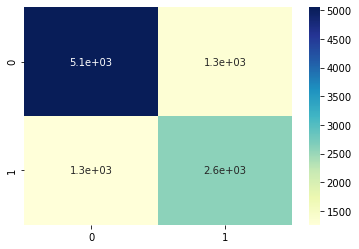

In [ ]:
import seaborn as sns
print(type(cm))
sns.heatmap(cm, annot=True,cmap="YlGnBu")

In [ ]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    q1 = nltk.word_tokenize(question1)  # tokenize
    q2 = nltk.word_tokenize(question2)  # tokenize
    Q1, Q2 = [], []
    for word in q1:  # encode q1
        Q1 += [vocab[word]]
    for word in q2:  # encode q2
        Q2 += [vocab[word]]
        
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    v1, v2 = model((Q1, Q2))
    d = np.dot(v1[0], v2[0].T)
    res = d > threshold
    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

**Test**

In [ ]:
question1 = "When will I see you?"
question2 = "When will I see you again?"
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   76    4   46   53 7287   21    1]]
d   =  0.92197174
res =  True


True

In [ ]:
question1 = "Where are you going?"
question2 = "When are you coming?"
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[ 676   87   53 1479   21    1    1    1]] 
Q2  =  [[ 585   87   53 1966   21    1    1    1]]
d   =  0.3656476
res =  False


False

In [ ]:
question1 = "Are you going to NIT?"
question2 = "Are you going to National Institute of Technology?"
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[ 520   53 1479   39 5162   21    1    1    1    1    1    1    1    1
     1    1]] 
Q2  =  [[ 520   53 1479   39 1196 3332  131 9908   21    1    1    1    1    1
     1    1]]
d   =  0.233315
res =  False


False

In [ ]:
question1 = "How do I read and find my YouTube comments?"
question2 = "How can I see all my Youtube comments?"
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[32 38  4 41 11 42 43 44 45 21  1  1  1  1  1  1]] 
Q2  =  [[32 33  4 46 47 43 48 45 21  1  1  1  1  1  1  1]]
d   =  0.57328355
res =  False


False

In [ ]:
question1 ="BTS Makes GRAMMYs History (Again) With Nomination for Dynamite"
question2 ="BTS Was Nominated For A 2021 Grammy & ARMYs Are Absolutely LOSING IT"
question3 ="BTS Finally Earn Their First Grammy Nomination"
question4 ="BTS make history as they land first ever Grammy Awards nomination"
predict(question1 , question2, 0.7, model, vocab, verbose = True)
predict(question3 , question4, 0.7, model, vocab, verbose = True)
predict(question2 , question3, 0.7, model, vocab, verbose = True)

Q1  =  [[    0     0     0 11191    24  3792    29  2559     0    65     0     1
      1     1     1     1]] 
Q2  =  [[   0 1247    0 2641  620    0    0  392    0  520    0    0 1718    1
     1    1]]
d   =  0.87073964
res =  True
Q1  =  [[    0     0 11285 11135 10556     0     0     1     1     1     1     1
      1     1     1     1]] 
Q2  =  [[    0    49  1774   251  1145  1495    57   174     0 23594  3472     1
      1     1     1     1]]
d   =  0.5483501
res =  False
Q1  =  [[   0 1247    0 2641  620    0    0  392    0  520    0    0 1718    1
     1    1]] 
Q2  =  [[    0     0 11285 11135 10556     0     0     1     1     1     1     1
      1     1     1     1]]
d   =  0.81467164
res =  True


True